<a href="https://colab.research.google.com/github/IkeKobby/fatima-fellowship/blob/main/Coding_Challenge_For_Fatima_Fellowship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fatima Fellowship Quick Coding Challenge (Pick 1)

Thank you for applying to the Fatima Fellowship. To help us select the Fellows and assess your ability to do machine learning research, we are asking that you complete a short coding challenge. Please pick **1 of these 5** coding challenges, whichever is most aligned with your interests. 

**Due date: 1 week**

**How to submit**: Please make a copy of this colab notebook, add your code and results, and submit your colab notebook to the submission link below. If you have never used a colab notebook, [check out this video](https://www.youtube.com/watch?v=i-HnvsehuSw).

**Submission link**: https://airtable.com/shrXy3QKSsO2yALd3

# 2. Deep Learning for NLP

**Fake news classifier**: Train a text classification model to detect fake news articles!

* Download the dataset here: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
* Develop an NLP model for classification that uses a pretrained language model
* Finetune your model on the dataset, and generate an AUC curve of your model on the test set of your choice. 
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* *Answer the following question*: Look at some of the news articles that were classified incorrectly. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
import pandas as pd
import numpy as np

In [85]:
clean_data_path = '/content/drive/MyDrive/Fatima_fellowship/40_percent.csv'

In [86]:
# Loading cleaned text. 
cleaned_data = pd.read_csv(clean_data_path)
cleaned_data.head(10)

,article,label,clean_article
0,MATT DAMON Says America Needs IMMEDIATE GUN BA...,0,matt damon says america needs immediate gun ba...
1,SEE GEORGE STEPHANOPOULOS’ Reaction When Hilla...,0,see george stephanopoulos reaction when hillar...
2,Listen To Ann Coulter Pretend She Likes Jews ...,0,listen to ann counter pretend she likes jews w...
3,Transcripts of Clinton's Wall Street talks rel...,1,transcripts clinton wall street talks released...
4,Jailed Cameroon writer who criticized governme...,1,jailed cameroon writer criticized government e...
5,Watch Bernie Sanders DESTROY Republican Ranti...,0,watch bernie sanders destroy republican rantin...
6,Kenya officials change way of announcing elect...,1,kenya officials change way announcing election...
7,HYSTERICAL: Trump Warns “Sleepy Eyes” Chuck To...,0,hysterical trump warns sleepy eyes chuck todd ...
8,"AMERICANS FURIOUS, Lash Out After Liberals Use...",0,americans furious lash out after liberals use ...
9,Dem Senator On Trump World: ‘They Lie As Easi...,0,dem senator on trump world they lie as easily ...


In [87]:
data_for_modeling = cleaned_data#[: int(len(cleaned_data) * .4)]
data_for_modeling.shape

(17959, 3)

In [88]:
# data_for_modeling.to_csv('40_percent.csv', index=False)

In [89]:
# data splitting 
train_input, validation_input, test_input = np.split(data_for_modeling['clean_article'], [int(.70 * len(data_for_modeling)), int(.90 * len(data_for_modeling))])
train_label, validation_label, test_label = np.split(data_for_modeling['label'], [int(.70 * len(data_for_modeling)), int(.90 * len(data_for_modeling))])

In [90]:
# reset indexes for validation and training
train_input = train_input.values
train_label = train_label.values
validation_input = validation_input.reset_index(drop = True).values
validation_label = validation_label.reset_index(drop = True).values
test_input = test_input.reset_index(drop = True).values
test_label = test_label.reset_index(drop = True).values

In [91]:
# check shapes
print(f"Train data: {train_input.shape} and Label: {len(train_label)}")
print(f"Validation data: {validation_input.shape} and Label: {len(validation_label)}")
print(f"Test data: {test_input.shape} and Label: {len(test_label)}")

assert len(data_for_modeling['clean_article']) == len(train_input) + len(validation_input) + len(test_input)
print(len(data_for_modeling['clean_article']))

Train data: (12571,) and Label: 12571
Validation data: (3592,) and Label: 3592
Test data: (1796,) and Label: 1796
17959


In [92]:
!pip install transformers

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertConfig
from sklearn.metrics import roc_auc_score

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [94]:
device

device(type='cuda')

In [95]:
MODEL_NAME = "distilbert-base-uncased"
TOKENIZER_NAME = "distilbert-base-uncased"
DISTILBERT_DROPOUT = 0.5
DISTILBERT_ATT_DROPOUT = 0.1
EPOCH = 2
MAX_SEQ_LEN = 512
BATCH_SIZE = 16
 
# Configure DistilBERT's initialization
config = DistilBertConfig(dropout=DISTILBERT_DROPOUT, 
                          attention_dropout=DISTILBERT_ATT_DROPOUT, 
                          output_hidden_states=True)

In [96]:
# custom dataset
class customTextDataset(Dataset):
  def __init__(self, input_text, text_label):
    self.input_text = input_text
    self.text_label = text_label

  def __len__(self,):
    return len(self.text_label)

  def __getitem__(self, index):
    text = self.input_text[index]
    label = self.text_label[index]
    return text, label

In [97]:
# ensuring conformity of the sequence length with collate function.
class batchCollate_function:
  def __init__(self, tokenizer_name):
    self.tokenizer_name = tokenizer_name
    self.tokenizer = DistilBertTokenizer.from_pretrained(self.tokenizer_name)

  def __call__(self, batch):
    batch_text  = [text[0] for text in batch]
    batch_labels = torch.tensor([label[1] for label in batch]).unsqueeze(0)
    encoded_texts = self.tokenizer(batch_text, padding=True, truncation=True, return_tensors="pt")
    return encoded_texts.to(device), batch_labels.to(device)

In [98]:
# Create instance for the dataset.
train_set = customTextDataset(train_input, train_label)
validation_set = customTextDataset(validation_input, validation_label)
test_set = customTextDataset(test_input, test_label,)

In [99]:
# create dataloaders
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=batchCollate_function(tokenizer_name = TOKENIZER_NAME))
validation_dataloader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=batchCollate_function(tokenizer_name = TOKENIZER_NAME))
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=batchCollate_function(tokenizer_name = TOKENIZER_NAME))

In [100]:
encoded_input, train_labels = next(iter(train_dataloader))
print(f"Text batch: {encoded_input['input_ids'][:2]}")
print(f"Labels batch: {train_labels}")

Text batch: tensor([[  101,  3422,  7252,  ...,     0,     0,     0],
        [  101,  2645,  2058,  ..., 22028,  2994,   102]], device='cuda:0')
Labels batch: tensor([[0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]], device='cuda:0')


In [101]:
# Customed pretrained model
class fakeNewsDistilBertClassifier(nn.Module):
  def __init__(self, model_name):
    super(fakeNewsDistilBertClassifier, self).__init__()

    self.model_name = model_name
    self.pretrained_distilbert = DistilBertForSequenceClassification.from_pretrained(model_name)

  def forward(self, inputs, labels):
    outputs = self.pretrained_distilbert(**inputs, labels=labels)
    return outputs

In [102]:
distilbert = fakeNewsDistilBertClassifier(model_name = MODEL_NAME).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

In [104]:
token = DistilBertTokenizer.from_pretrained(TOKENIZER_NAME)
inp_ = token("I am Kobby, the tech Boss of TechSol Inc.", return_tensors="pt")
label = torch.tensor([1])

out = distilbert(inp_.to(device), label.to(device))
out.logits.data

tensor([[-0.0733,  0.1357]], device='cuda:0')

In [105]:
# from helper_functions import *
optimizer = optim.Adam(distilbert.parameters(), lr=2e-5)

def save_checkpoint(save_path, model, valid_loss):

    if save_path is None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path is None:
        return

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}

    torch.save(state_dict, save_path)
    print(f'Metrics saved to ==> {save_path}')

In [106]:
destination_folder = '/content/drive/MyDrive/Fatima_fellowship/training'

# Training Function
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_dataloader,
          valid_loader = validation_dataloader,
          num_epochs = EPOCH,
          eval_every = len(train_dataloader) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
  
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    # roc_auc = 0.0

    # training loop
    model.train()
    for epoch in range(num_epochs):
      for (input_ids, labels) in train_loader:
        # forward pass
        outputs = model(input_ids, labels)
        # compute loss
        loss = outputs.loss
        # zero the parameter gradients
        optimizer.zero_grad()
        # compute gradient
        loss.backward()
        # update gradient
        optimizer.step()

        # update running values
        running_loss += loss.item()
        global_step += 1

        # evaluation step
        if global_step % eval_every == 0:
          model.eval()
          with torch.no_grad():
            for (valid_input_ids, valid_labels) in valid_loader:
                valid_outputs = model(valid_input_ids, valid_labels)
                
                loss = valid_outputs.loss
                valid_running_loss += loss.item()

          # evaluation metrics
          average_train_loss = running_loss / eval_every
          average_valid_loss = valid_running_loss / len(valid_loader)
          train_loss_list.append(average_train_loss)
          valid_loss_list.append(average_valid_loss)
          global_steps_list.append(global_step)

          # resetting running values
          running_loss = 0.0                
          valid_running_loss = 0.0
          # roc_auc = 0.0
          model.train()

          # print progress
          print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                        average_train_loss, average_valid_loss))
            
          # checkpoint
          if best_valid_loss > average_valid_loss:
              best_valid_loss = average_valid_loss
              save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
              save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [ ]:
#training
train(model=distilbert, optimizer=optimizer)

Epoch [1/2], Step [393/1572], Train Loss: 0.0101, Valid Loss: 0.0031
Model saved to ==> /content/drive/MyDrive/Fatima_fellowship/training/model.pt
Metrics saved to ==> /content/drive/MyDrive/Fatima_fellowship/training/metrics.pt
Epoch [1/2], Step [786/1572], Train Loss: 0.0091, Valid Loss: 0.0039
Epoch [2/2], Step [1179/1572], Train Loss: 0.0031, Valid Loss: 0.0018
Model saved to ==> /content/drive/MyDrive/Fatima_fellowship/training/model.pt
Metrics saved to ==> /content/drive/MyDrive/Fatima_fellowship/training/metrics.pt
Epoch [2/2], Step [1572/1572], Train Loss: 0.0023, Valid Loss: 0.0026
Metrics saved to ==> /content/drive/MyDrive/Fatima_fellowship/training/metrics.pt
Finished Training!


In [107]:
def load_checkpoint(load_path, model):
    
    if load_path is None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

In [108]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
def evalaute(model, test_loader):
  y_pred = []
  y_true = []

  model.eval()
  with torch.no_grad():
    for (test_inputs, test_label) in test_loader:
      output = model(test_inputs, test_label)
      output = output.logits.data
      y_pred.extend(torch.argmax(output, 1).tolist())
      y_true.extend(test_label[0].tolist())
  return y_true, y_pred

model_ = distilbert
load_checkpoint(destination_folder + '/model.pt', model_)

y_true, y_pred = evalaute(model_, test_dataloader)

Model loaded from <== /content/drive/MyDrive/Fatima_fellowship/training/model.pt


ROC-AUC Score: 1.0
Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       936
           1       1.00      1.00      1.00       860

    accuracy                           1.00      1796
   macro avg       1.00      1.00      1.00      1796
weighted avg       1.00      1.00      1.00      1796



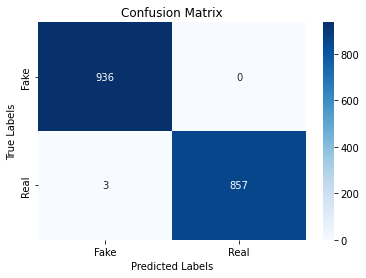

In [110]:
def visualize_evaluation(y_true, y_pred):
  print(f"ROC-AUC Score: {round(roc_auc_score(y_true, y_pred), 2)}")
  print('Classification report: ')
  print(classification_report(y_true, y_pred))

  cm = confusion_matrix(y_true, y_pred)
  ax =plt.subplot()
  sns.heatmap(cm, annot=True, ax=ax, cmap = 'Blues', fmt ='d')
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')
  ax.xaxis.set_ticklabels(['Fake', 'Real'])
  ax.yaxis.set_ticklabels(['Fake', 'Real'])
visualize_evaluation(y_true, y_pred)

In [113]:
int(.90 * len(data_for_modeling))

16163

In [121]:
# Get the orignal article
data_with_predictions = data_for_modeling[['article']]
data_with_predictions = data_with_predictions[int(.90 * len(data_for_modeling)):].reset_index(drop = True)
data_with_predictions['predictions'] = y_pred
data_with_predictions['true_labels'] = y_true
data_with_predictions

,article,predictions,true_labels
0,COLIN POWELL SAYS HILLARY LYING About Private ...,1,1
1,Oregon Ranchers Who Started Bundy Occupation ...,0,0
2,80 YEAR OLD MAN Writes MUST READ Letter To RNC...,1,1
3,WATCH: Trump Misses Deadline To Provide Proof...,1,1
4,Mexico enacts law to help find thousands missi...,1,1
...,...,...,...
1791,WOW! Watch Former Democrat Hammer Obama On His...,0,0
1792,BILL CLINTON STEPS IN IT: Accuses FBI Of Servi...,0,0
1793,Indian tycoon's extradition hearing told of ab...,1,1
1794,Russian 'propaganda on steroids' aimed at 2016...,1,1


In [124]:
# confirm the true data
pd.DataFrame(test_input, columns = ['article'])

,article
0,colin powell says hillary lying about private ...
1,oregon ranchers who started buddy occupation t...
2,year old man writes must read letter to rnc to...
3,watch trump misses deadline to provide proof o...
4,mexico enact law help find thousands missing g...
...,...
1791,wow watch former democrat hammer obama on his ...
1792,bill clinton steps in it accuses fbi of servin...
1793,indian tycoon extradition hearing told abuse u...
1794,russian steroids aimed election lawmakerwashin...


In [127]:
# Wrong predictions
wrong_predictions = data_with_predictions[data_with_predictions['true_labels'] != data_with_predictions['predictions']]
wrong_predictions

,article,predictions,true_labels
73,Trump pulls out of Republican debate in IowaMA...,0,1
799,OBAMA WILL GIVE AWAY FREE INTERNET (To Those H...,0,1
1305,HOW A SINGLE FEDERAL BUREAUCRAT OPENED THE DOO...,0,1


- These three articles the model misclassified them. Interestingly there is some kind of a particular confusion the models has learned in that it predicts almost all three `real` articles as `fake`. But I am curious because the model seem to predict the text with `id --> 799` right as `fake`. 

In [136]:
# id 799
wrong_predictions.iloc[1, : ][0]

'OBAMA WILL GIVE AWAY FREE INTERNET (To Those He Deems Worthy) : “The internet is not a luxury”Don t turn off your paid internet service quite yet. If you have a job and contribute to our tax base, you won t qualify. You also have to be living in cities the Obama regime considers worthy of free internet service. Those cities have likely provided some form of support for Obama s radical agenda for America.Because internet service is a human right or something like that Calling the Internet a 21st century necessity, President Barack Obama on Wednesday unveiled a program to bring faster Internet connections to more low-income households, particularly to help students living in public and assisted housing stay ahead in school.Under ConnectHome, the public, private and nonprofit sectors have pledged to work together to provide high-speed connections and digital devices to more families at lower cost.More than 90 percent of households headed by a college graduate have Internet access, Obama 

- Well, I don't know when exactly this happened in the US though but it looks so good to be true anyway.  How those rather contributing to tax base and have jobs not qualify? You think the model is indeed wrong or the labeling is wrong. Indeed I think a better way to get the right answers is to google the authenticity of this news article to know whether or this did happen. 
- Oh guess what, after fidgeting with my keyboard on google, [here](https://100percentfedup.com/obama-will-give-away-free-internet-to-those-he-deems-worthy-the-internet-is-not-a-luxury/) is what I found, a 2015 based article. What I think is that the context of the news was more reasonable as it was shown here in the text. It suffice to say that the source and the conveyance of the news also matters because humanly thinking, if I saw this at a first glance I'd have same doubts like my model too. Hahahahah 🤣!!!!


- Finally, here's what I think I would do. I had earlier trained tensorflow based model using `distilbert-base-uncased` and achieved incredible results on a `30%` of the same data. Almost the model get confused in a similar way. I will find myself some good `gpu` and utilize all on the data. This model is performance on only `40%` of the dataset. 

**Write up**: 
* Link to the model on Hugging Face Hub: 
* Include some examples of misclassified news articles. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)